In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE =32
CHANNELS = 3
EPOCHS = 50

In [ ]:
import os

# Chemins des sous-dossiers
Normal_folder = "/content/drive/MyDrive/Model_3_infectieux_types/Normal"
COVID_folder = "/content/drive/MyDrive/Model_3_infectieux_types/COVID"
CAP_folder = "/content/drive/MyDrive/Model_3_infectieux_types/CAP"

# Fonction pour compter les fichiers dans un dossier
def count_images(folder_path):
    return len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])

# Compter les images dans chaque sous-dossier
Normal_count = count_images(Normal_folder)
COVID_count = count_images(COVID_folder)
CAP_count = count_images(CAP_folder)

# Afficher le nombre d'images dans chaque dossier
print(f"Nombre d'images dans le dossier 'Normal' : {Normal_count}")
print(f"Nombre d'images dans le dossier 'COVID' : {COVID_count}")
print(f"Nombre d'images dans le dossier 'large.cell.carcinoma' : {CAP_count}")


Nombre d'images dans le dossier 'Normal' : 4649
Nombre d'images dans le dossier 'COVID' : 3732
Nombre d'images dans le dossier 'large.cell.carcinoma' : 2618


In [ ]:
import os
import shutil
import random

source_dir = "/content/drive/MyDrive/Model_3_infectieux_types"
target_dir = "/content/drive/MyDrive/model_3_infectieux_types_structurer"

# Crée le dossier cible s'il n'existe pas
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Limite le nombre d'images par classe à 700
limit_per_class = 1400

for class_name in os.listdir(source_dir):
    class_dir = os.path.join(source_dir, class_name)
    if os.path.isdir(class_dir):
        # Sélectionne aléatoirement 1400 images
        images = os.listdir(class_dir)
        selected_images = random.sample(images, min(len(images), limit_per_class))

        # Crée le dossier de la classe cible
        target_class_dir = os.path.join(target_dir, class_name)
        os.makedirs(target_class_dir, exist_ok=True)

        # Copie les images sélectionnées
        for image_name in selected_images:
            source_path = os.path.join(class_dir, image_name)
            target_path = os.path.join(target_class_dir, image_name)
            shutil.copy(source_path, target_path)


In [ ]:
import os

# Chemins des sous-dossiers
Normal_folder = "/content/drive/MyDrive/model_3_infectieux_types_structurer/Normal"
COVID_folder = "/content/drive/MyDrive/model_3_infectieux_types_structurer/COVID"
CAP_folder = "/content/drive/MyDrive/model_3_infectieux_types_structurer/CAP"

# Fonction pour compter les fichiers dans un dossier
def count_images(folder_path):
    return len([file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))])

# Compter les images dans chaque sous-dossier
Normal_count = count_images(Normal_folder)
COVID_count = count_images(COVID_folder)
CAP_count = count_images(CAP_folder)

# Afficher le nombre d'images dans chaque dossier
print(f"Nombre d'images dans le dossier 'Normal' : {Normal_count}")
print(f"Nombre d'images dans le dossier 'COVID' : {COVID_count}")
print(f"Nombre d'images dans le dossier 'CAP' : {CAP_count}")


Nombre d'images dans le dossier 'Normal' : 1400
Nombre d'images dans le dossier 'COVID' : 1400
Nombre d'images dans le dossier 'CAP' : 1400


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/model_3_infectieux_types_structurer",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4200 files belonging to 3 classes.


In [ ]:
class_name = dataset.class_names
class_name

['CAP', 'COVID', 'Normal']

In [ ]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 224, 224, 3)
[2 2 0 0 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 2 2 2 0 1 1 1 2 0 2 0 2]


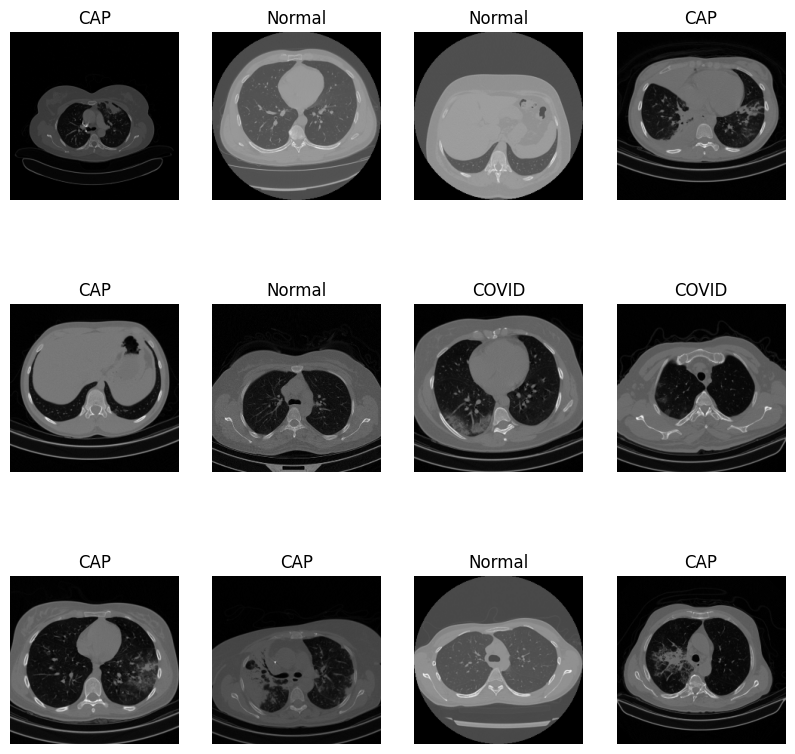

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        ax.imshow(image_batch[i].numpy().astype('uint8'))
        ax.set_title(class_name[label_batch[i].numpy()])
        ax.axis("off")
plt.show()


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

105

In [ ]:
len(val_ds)

13

In [ ]:
len(test_ds)

14

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    #layers.RandomRotation(0.2),
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = tf.keras.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # Spécifie la forme des données d'entrée
    resize_and_rescale,  # Redimensionnement et normalisation
    data_augmentation,   # Augmentation des données
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = 100,
    batch_size = 32,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 74s 380ms/step - accuracy: 0.5300 - loss: 2.2440 - val_accuracy: 0.6370 - val_loss: 0.7931
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.6749 - loss: 0.7123 - val_accuracy: 0.6851 - val_loss: 0.7020
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.7123 - loss: 0.6677 - val_accuracy: 0.7163 - val_loss: 0.6483
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.7098 - loss: 0.6498 - val_accuracy: 0.7284 - val_loss: 0.6210
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.7410 - loss: 0.6157 - val_accuracy: 0.6635 - val_loss: 0.6583
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.7514 - loss: 0.5876 - val_accuracy: 0.7692 - val_loss: 0.5690
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.7728 - loss: 0.5530 - val_accuracy: 0.7188 - val_loss: 0.6466
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.7827 - loss: 0

In [ ]:
model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.8951 - loss: 0.3087


[0.25259846448898315, 0.9107142686843872]

In [ ]:
def predict_single(model, img, class_name):
    # Convertir l'image en tableau numpy et ajouter une dimension
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Ajouter une dimension (batch)

    # Faire des prédictions
    predictions = model.predict(img_array)
    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


In [ ]:
def predict_dataset(model, dataset, class_names):
    y_true = []
    y_pred = []

    # Parcourir le dataset pour faire des prédictions
    for images, labels in dataset:
        predictions = model.predict(images)
        predicted_classes = np.argmax(predictions, axis=1)
        y_pred.extend(predicted_classes)
        y_true.extend(labels.numpy())  # Ajouter les étiquettes vraies

    return np.array(y_true), np.array(y_pred)


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Prédire sur le dataset de test
y_true, y_pred = predict_dataset(model, test_ds, class_name)

# Générer le rapport de classification
report = classification_report(y_true, y_pred, target_names=class_name)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
              precision    recall  f1-score   support

         CAP       0.99      0.94      0.96       149
       COVID       0.91      0.87      0.89       159
      Normal       0.84      0.93      0.88       140

    accuracy                           0.91       448
   macro avg       0.91      0.91      0.91       448
weighted avg       0.91      0.91      0.91       448



In [ ]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


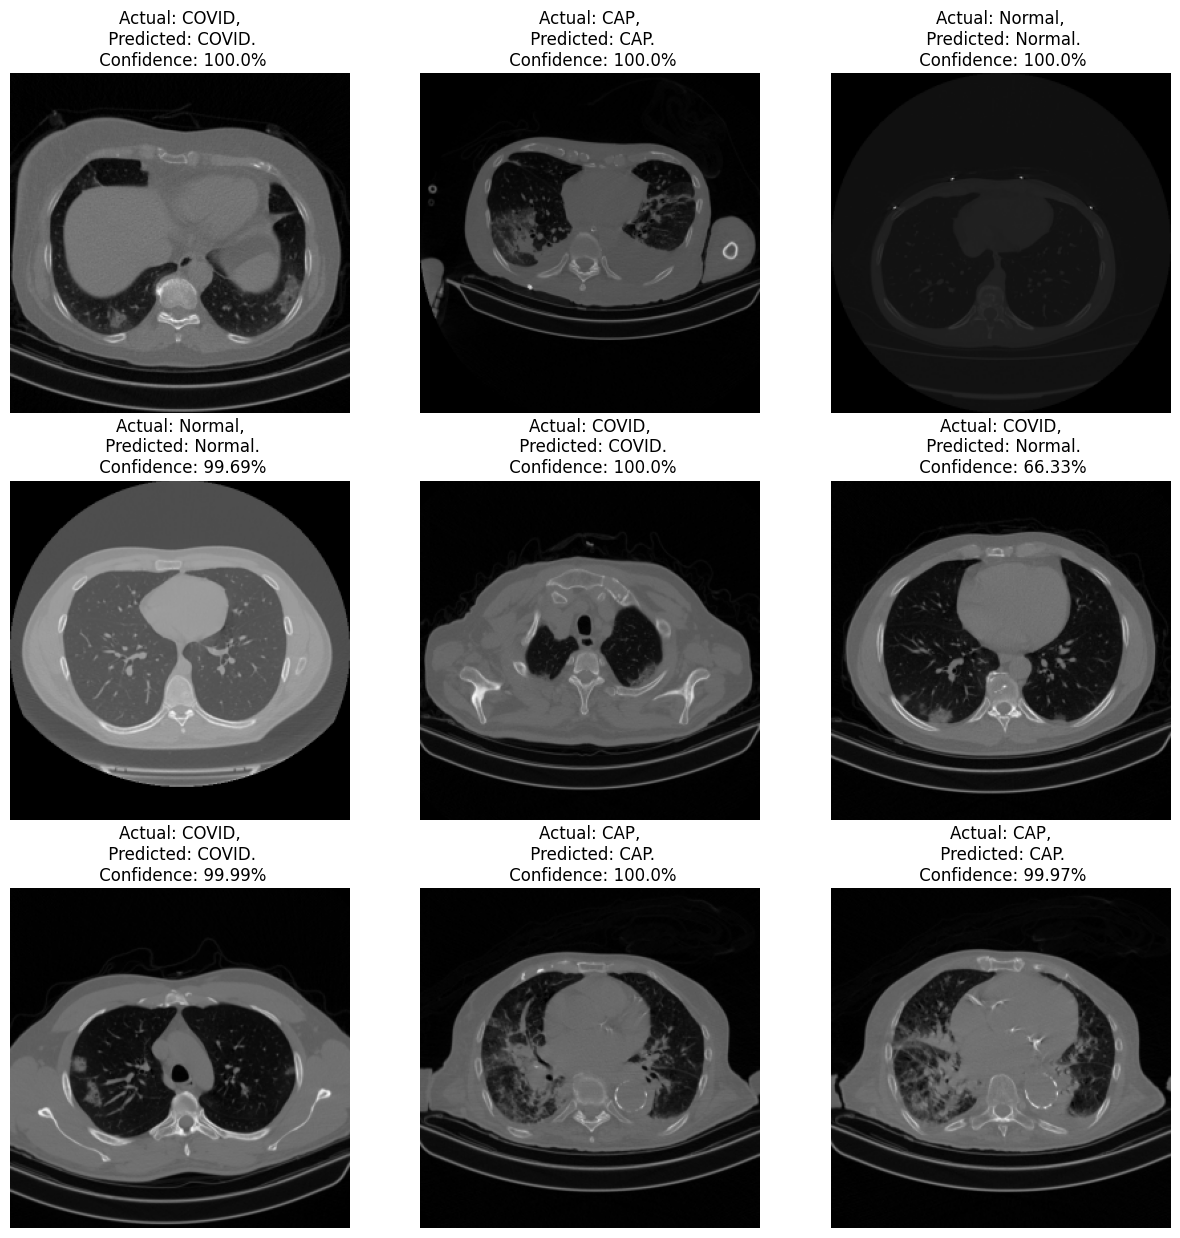

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict(model, images)
    actual_class = class_name[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis('off')


In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = tf.keras.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # Spécifie la forme des données d'entrée
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])


In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
model.fit(
    train_ds,
    epochs = 100,
    batch_size = 32,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 15s 110ms/step - accuracy: 0.5192 - loss: 0.9914 - val_accuracy: 0.6226 - val_loss: 0.7388
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.6467 - loss: 0.7404 - val_accuracy: 0.6538 - val_loss: 0.7321
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.6799 - loss: 0.7161 - val_accuracy: 0.6995 - val_loss: 0.6566
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 101ms/step - accuracy: 0.6864 - loss: 0.6712 - val_accuracy: 0.6875 - val_loss: 0.6826
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - accuracy: 0.7100 - loss: 0.6423 - val_accuracy: 0.6659 - val_loss: 0.6908
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.7296 - loss: 0.6102 - val_accuracy: 0.7788 - val_loss: 0.5232
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.7298 - loss: 0.6072 - val_accuracy: 0.7812 - val_loss: 0.5330
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.7663 -

In [ ]:
model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9311 - loss: 0.1682


[0.19784501194953918, 0.9263392686843872]

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Prédire sur le dataset de test
y_true, y_pred = predict_dataset(model, test_ds, class_name)

# Générer le rapport de classification
report = classification_report(y_true, y_pred, target_names=class_name)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
              precision    recall  f1-score   support

         CAP       0.93      0.97      0.95       149
       COVID       0.96      0.84      0.89       159
      Normal       0.90      0.99      0.94       140

    accuracy                           0.93       448
   macro avg       0.93      0.93      0.93       448
weighted avg       0.93      0.93      0.93       448



In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = tf.keras.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # Spécifie la forme des données d'entrée
    resize_and_rescale,  # Redimensionnement et normalisation
    data_augmentation,   # Augmentation des données
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
model.fit(
    train_ds,
    epochs = 100,
    batch_size = 32,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 167s 399ms/step - accuracy: 0.4786 - loss: 7.6884 - val_accuracy: 0.5913 - val_loss: 0.8749
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 47s 101ms/step - accuracy: 0.6138 - loss: 0.8318 - val_accuracy: 0.5697 - val_loss: 0.8478
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.6396 - loss: 0.7903 - val_accuracy: 0.6346 - val_loss: 0.7807
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.6378 - loss: 0.7575 - val_accuracy: 0.6274 - val_loss: 0.7746
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 102ms/step - accuracy: 0.6752 - loss: 0.7130 - val_accuracy: 0.6538 - val_loss: 0.8207
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.6713 - loss: 0.7428 - val_accuracy: 0.6394 - val_loss: 0.7158
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 104ms/step - accuracy: 0.6765 - loss: 0.7150 - val_accuracy: 0.6659 - val_loss: 0.7130
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.6886 

In [ ]:
model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.7738 - loss: 0.6061


[0.5728539824485779, 0.7834821343421936]

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = tf.keras.Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # Spécifie la forme des données d'entrée
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])


In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs = 100,
    batch_size = 32,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 83s 367ms/step - accuracy: 0.5392 - loss: 0.9310 - val_accuracy: 0.7043 - val_loss: 0.7242
Epoch 2/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.7413 - loss: 0.6262 - val_accuracy: 0.7764 - val_loss: 0.5507
Epoch 3/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.7809 - loss: 0.5459 - val_accuracy: 0.8269 - val_loss: 0.4489
Epoch 4/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.8177 - loss: 0.4580 - val_accuracy: 0.8534 - val_loss: 0.3614
Epoch 5/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.8610 - loss: 0.3592 - val_accuracy: 0.8798 - val_loss: 0.3300
Epoch 6/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.8800 - loss: 0.3387 - val_accuracy: 0.8534 - val_loss: 0.3445
Epoch 7/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.8769 - loss: 0.3136 - val_accuracy: 0.9303 - val_loss: 0.1988
Epoch 8/100
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.9020 - loss: 0.25

In [ ]:
model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - accuracy: 0.9840 - loss: 0.2736


[0.16928930580615997, 0.9910714030265808]

In [ ]:
#model.evaluate(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9436 - loss: 0.2089


[0.187164306640625, 0.9464285969734192]

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Prédire sur le dataset de test
y_true, y_pred = predict_dataset(model, test_ds, class_name)

# Générer le rapport de classification
report = classification_report(y_true, y_pred, target_names=class_name)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
              precision    recall  f1-score   support

         CAP       0.99      1.00      1.00       143
       COVID       0.98      1.00      0.99       158
      Normal       1.00      0.97      0.99       147

    accuracy                           0.99       448
   macro avg       0.99      0.99      0.99       448
weighted avg       0.99      0.99      0.99       448



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


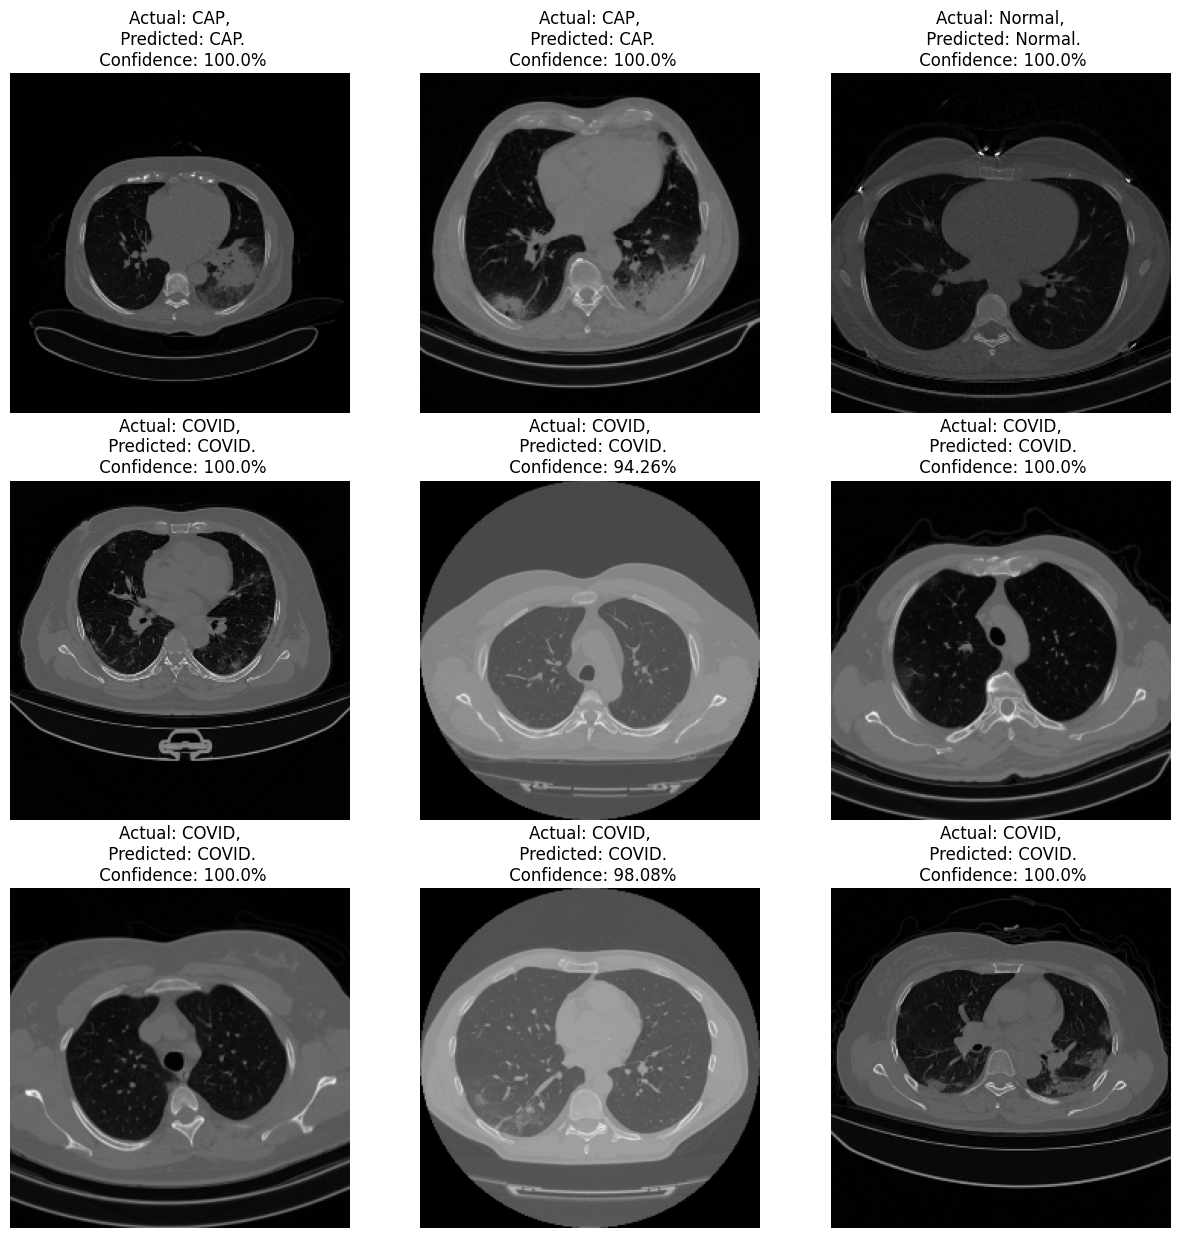

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict(model, images)
    actual_class = class_name[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

    plt.axis('off')


In [ ]:
model.save("/content/drive/MyDrive/CT_model_3_v2.keras")

In [ ]:
model.export("/content/drive/MyDrive/CT_model_3_v2")

Saved artifact at '/content/drive/MyDrive/CT_model_3_v2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135138112633520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135138112760720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135138131560576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135138107923920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135138107923568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135140383448352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135138107927264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135138108001792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135138108001616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135138107998448: TensorSpec(shape=(), dtype=tf.resource, name=No

### Transfer Learning

In [ ]:
#!pip install tensorflow==2.13.0
#!pip install --upgrade tensorflow-hub

import numpy as np
import cv2

import PIL
import PIL.Image as Image
import os
import datetime
import time


%load_ext tensorboard
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/model_3_infectieux_types_structurer",
    shuffle = True,
    image_size = (224, 224),
    batch_size = 32
)

Found 4200 files belonging to 3 classes.


In [ ]:
class_name = dataset.class_names
class_name

['CAP', 'COVID', 'Normal']

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor_model = mobilenet_v2


In [ ]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# Assuming you have 'data_augmentation' and 'feature_extractor_layer' defined

num_classes = len(class_name)

# Wrap the feature_extractor_layer in a tf.keras.layers.Layer using the Lambda layer
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(224, 224, 3)), # Define input shape here
  data_augmentation,
  tf.keras.layers.Lambda(lambda x: feature_extractor_layer(x)),  # Wrap with Lambda layer
  tf.keras.layers.Dense(num_classes)
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,843 (15.01 KB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "/content/logs2/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.


In [ ]:
NUM_EPOCHS = 200

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 211s 767ms/step - acc: 0.5522 - loss: 0.9038 - val_acc: 0.7452 - val_loss: 0.6413
Epoch 2/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - acc: 0.7414 - loss: 0.5900 - val_acc: 0.7572 - val_loss: 0.5815
Epoch 3/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - acc: 0.7852 - loss: 0.5163 - val_acc: 0.7524 - val_loss: 0.5591
Epoch 4/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - acc: 0.7934 - loss: 0.4904 - val_acc: 0.7596 - val_loss: 0.5527
Epoch 5/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - acc: 0.7907 - loss: 0.4826 - val_acc: 0.8005 - val_loss: 0.5046
Epoch 6/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - acc: 0.8261 - loss: 0.4423 - val_acc: 0.7837 - val_loss: 0.4784
Epoch 7/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - acc: 0.8168 - loss: 0.4257 - val_acc: 0.7692 - val_loss: 0.5304
Epoch 8/200
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - acc: 0.8192 - loss: 0.4407 - val_acc: 0.7885 - val_loss: 0.5151
Epoch 9/200
105/105 ━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [ ]:
model.evaluate(test_ds)

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_name[predicted_id]
print(predicted_label_batch)


In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")
